# Уравнение диффузии в цилиндрических координатах

Задача о нестационарной диффузии с неоднородным граничным условием:

$$ \frac{\partial \tilde{u}}{\partial t} = D \Delta \tilde{u} = D \left( \frac{\partial^2 \tilde{u}}{\partial r^2} + \frac{1}{r} \frac{\partial \tilde{u}}{\partial r} \right), \quad \tilde{u}(t=0) = \tilde{\varphi}(r), \quad \tilde{u}(r=R) = u_0. $$

Задача о нестационарной диффузии с однородным граничным условием с нулевым начальным распределением:

$$ \frac{\partial u}{\partial t} = D \left( \frac{\partial^2 u}{\partial r^2} + \frac{1}{r} \frac{\partial u}{\partial r} \right), \quad u(t=0) = \varphi(r) = -u_0, \quad u(r=R) = 0, \quad \tilde{u} = u + u_0, \quad \tilde{\varphi}(r)=0.$$

Общее решение этой краевой задачи внутри цилиндра имеет вид:

$u(r,t) = \sum_{k=1}^{\infty} C_k e^{-\lambda^2_kDt}J_0(\lambda_kr),$ где $J_0$ - функция Бесселя нулевого порядка, $\lambda_k = \mu_k/R$, $\mu_k$ - нули функции Бесселя нулевого порядка.
Коэффициенты разложения $C_k$ выражаются в виде:
$C_k = \frac{2}{J_0^{\prime 2}(\mu_k)} \int_0^1 x J_0(\mu_kx) \varphi(Rx)dx$.

## Решение уравнения диффузии во внутренней области цилиндра 

RuntimeError: Requested MovieWriter (ffmpeg) not available

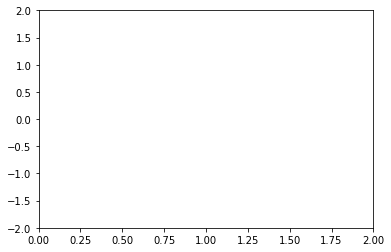

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv as J
from scipy.special import jvp as Jderiv
from scipy.special import jn_zeros as Jzeros

R = 1.
D = 0.01
u0 = 1.
Ncoef = 50

Ntimesteps = 101
Nspacesteps = 101

t = 1.
r = np.linspace(0, R, Nspacesteps)
mu = Jzeros(0,Ncoef)
lambd = mu/R
C = np.empty(Ncoef,float)
u = np.zeros(Nspacesteps,float)

#def f(x,i):
#    return -u0*x*J(0,mu[i]*x)

for i in range(Ncoef):
    C[i] = 2./Jderiv(0,mu[i])**2*(-u0)*J(1,mu[i])/mu[i]
    u += C[i]*np.exp(-lambd[i]**2*D*t)*J(0,lambd[i]*r)
u = u0 + u

from matplotlib import animation, rc
from IPython.display import HTML
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

#HTML(anim.to_html5_video())
rc('animation', html='html5')
anim

#plt.plot(r,u)
#plt.show()

## Решение уравнения диффузии между двумя цилиндрическими слоями с постоянными концентрациями

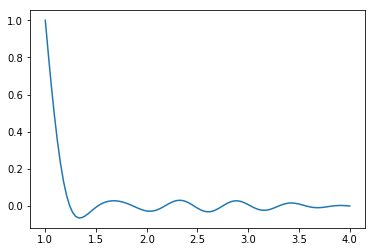

In [69]:
from scipy.special import j0 as J
from scipy.special import y0 as Y
from scipy.optimize import fsolve

def f(x):
    return J(R0*x)*Y(Rmax*x)-J(Rmax*x)*Y(R0*x)

R0 = 1.
Rmax = 4*R0
r = np.linspace(R0, Rmax, Nspacesteps)
t = 0.5
u1 = 1.
u2 = 0.
Ncoef = 10

# Stationary distibution
u = (u1*np.log(Rmax/r)-u2*np.log(r/R0))/np.log(Rmax/R0)
zeros = fsolve(f,np.linspace(1,Ncoef,Ncoef))

for i in range(Ncoef):
    U = J(zeros[i]*r)*Y(zeros[i]*Rmax) - J(zeros[i]*Rmax)*Y(zeros[i]*r)
    u += -np.pi*(u2*J(R0*zeros[i])-u1*J(Rmax*zeros[i]))*J(R0*zeros[i])*U/(J(R0*zeros[i])**2 - J(Rmax*zeros[i])**2)*np.exp(-zeros[i]**2*D*t)

uBessel = u
plt.plot(r,u)
plt.show()

## Анимация

# Конечные разности

In [58]:
def FindValue(u):
    res = 0
    for i in range(u.size):
        if u[i]<0.01*u[0]:
            res = i
            break
    return res

## Уравнение диффузии. Неявная схема. Одномерная задача

In [66]:
def ImpliciteSchema():
    u = np.copy(uzero)
    unew = np.empty(N+1,float)
    frac = h**2/D/tau
    Aw = np.empty(N+1,float)
    Ap = np.empty(N+1,float)
    Ae = np.empty(N+1,float)
    Q = np.empty(N+1,float)
    
    front = np.empty(Ntimesteps, int)
    for t in range(Ntimesteps):
        for i in range(1,N):
            Aw[i] = 1.
            Ap[i] = -2.-frac
            Ae[i] = 1.
            Q[i] = -frac*u[i]
        Ae[0] = 0
        Ap[0] = 1.
        Q[0] = uzero[0]
        
        for i in range(1,N+1):
            Ap[i] = Ap[i] - Aw[i]*Ae[i-1]/Ap[i-1]
            Q[i] = Q[i] - Aw[i]*Q[i-1]/Ap[i-1]
        unew[N] = uzero[N]
        for i in range(N-1,-1,-1):
            unew[i] = (Q[i]-Ae[i]*unew[i+1])/Ap[i]
        u = unew
        front[t] = FindValue(u)
    return u, front

## Уравнение диффузии. Явная схема. Одномерная задача

In [67]:
def ExpliciteSchema():
    u = np.copy(uzero)
    unew = np.empty(N+1,float)
    unew[0] = uzero[0]
    unew[N] = uzero[N]
    print('Максимальный шаг по времени для устойчивой явной схемы: ', 0.5*h**2/D, ', фактический шаг: ', tau)
    frac = tau*D/h**2
    front = np.empty(Ntimesteps, int)
    for t in range(Ntimesteps):
        for i in range(1,N):
            unew[i] = u[i] + frac*(u[i+1]-2*u[i]+u[i-1]) #0.5*(u[i+1]-u[i-1])/(100+i)
        u = unew
        front[t] = FindValue(u)
    return u, front

## Сравнение явной и неявной схем

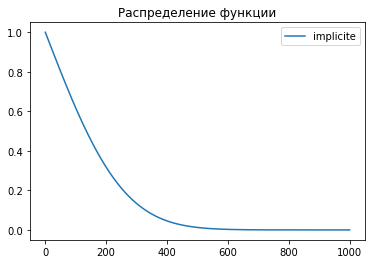

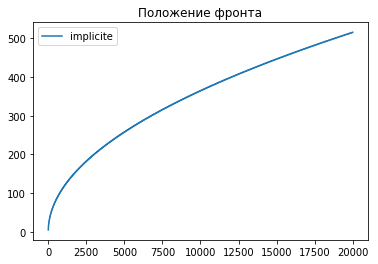

In [69]:
N = 100
Ntimesteps = 20000
D = 0.01
tau = 0.01
L = 10.
h = L/N
u0 = 1.
uzero = np.zeros(N+1,float)
uzero[0] = u0

uImplicite, frontImplicite = ImpliciteSchema()
#uExplicite, frontExplicite = ExpliciteSchema()
plt.plot(uImplicite, label = 'implicite')
#plt.plot(uExplicite, label = 'explicite')
plt.legend()
plt.title('Распределение функции')
plt.show()
plt.plot(frontImplicite, label = 'implicite')
#plt.plot(frontExplicite, label = 'explicite')
plt.title('Положение фронта')
plt.legend()
plt.show()

## Аппроксимация фронта диффузии

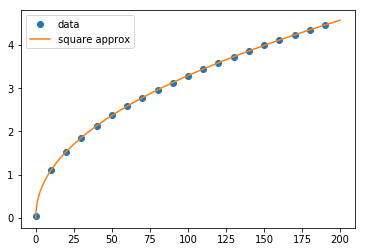

In [94]:
def func(x, a, b):
    return a * x**b

y = frontImplicite*h
x = np.arange(0,Ntimesteps*tau,tau)
from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, x, y)
plt.plot(x[::1000],y[::1000],'o',label='data')
plt.plot(x,func(x,*popt),label='square approx')
plt.legend()
plt.show()

## Зависимомость скорости диффузии в 1D и в 2D конфигурациях

In [49]:
def ImpliciteSchemaPolar():
    u = np.copy(uzero)
    unew = np.empty(N+1,float)
    frac = h**2/D/tau
    Aw = np.empty(N+1,float)
    Ap = np.empty(N+1,float)
    Ae = np.empty(N+1,float)
    Q = np.empty(N+1,float)
    
    front = np.empty(Ntimesteps, int)
    for t in range(Ntimesteps):
        for i in range(1,N):
            Aw[i] = 1.-0.5/(N0+i)
            Ap[i] = -2.-frac
            Ae[i] = 1.+0.5/(N0+i)
            Q[i] = -frac*u[i]
        Ae[0] = 0
        Ap[0] = 1.
        Q[0] = uzero[0]
        
        for i in range(1,N+1):
            Ap[i] = Ap[i] - Aw[i]*Ae[i-1]/Ap[i-1]
            Q[i] = Q[i] - Aw[i]*Q[i-1]/Ap[i-1]
        unew[N] = uzero[N]
        for i in range(N-1,-1,-1):
            unew[i] = (Q[i]-Ae[i]*unew[i+1])/Ap[i]
        u = unew
        front[t] = FindValue(u)
    return u, front

In [101]:
R0 = 0.5
Rmax = 10*R0
Nspacesteps = 1001
N = Nspacesteps-1
h = (Rmax-R0)/N
N0 = R0//h
tau = 0.01
Ntimesteps = (int)(5/tau)
uzero = np.zeros(N+1,float)
uzero[0] = u0

print(r.size, uImplicite.size, uBessel.size)
uImplicite, frontImplicite = ImpliciteSchemaPolar()
plt.plot(r,uImplicite, 'o', label = 'implicite')
plt.plot(r,uBessel, label = 'implicite')
plt.title('Распределение функции')
plt.show()
plt.plot(frontImplicite, label = 'implicite')
plt.title('Положение фронта')
plt.show()

101 1001 101


KeyboardInterrupt: 

0.001 0.11713673421291017


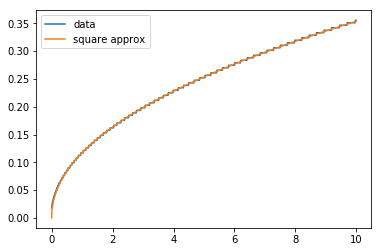

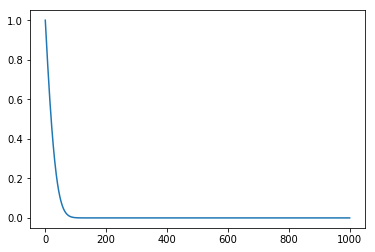

0.005 0.2553988343549772


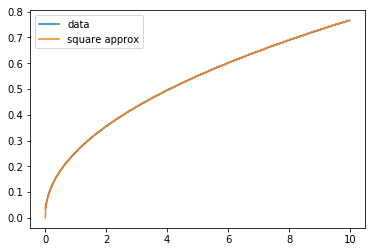

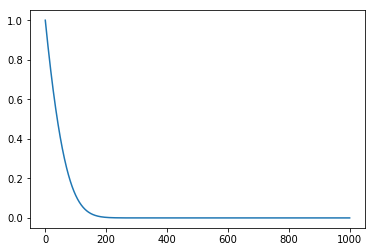

0.01 0.3571163678681237


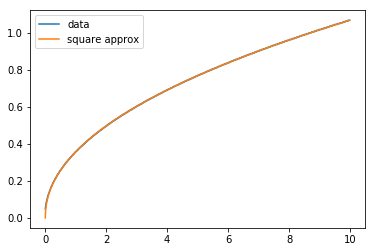

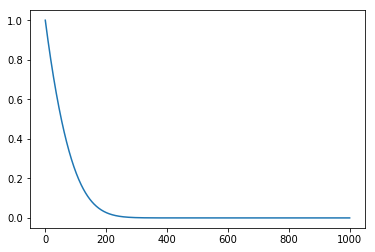

0.05 0.7733284700673888


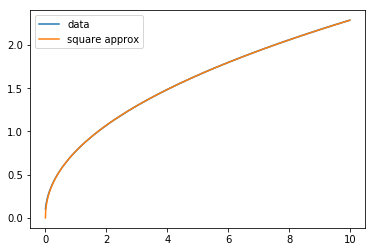

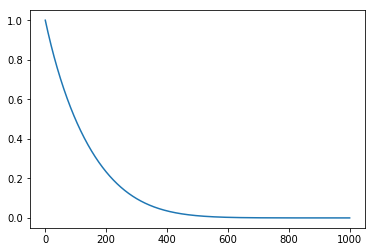

0.1 1.0759388712851616


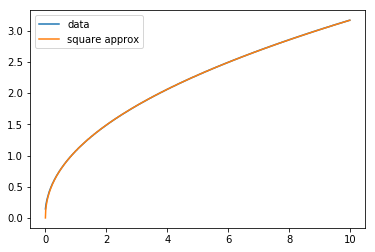

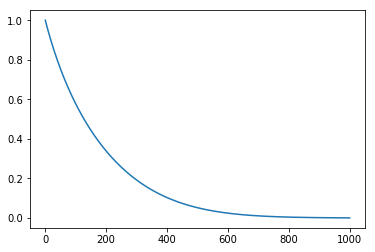

0.2 1.5407679653614361


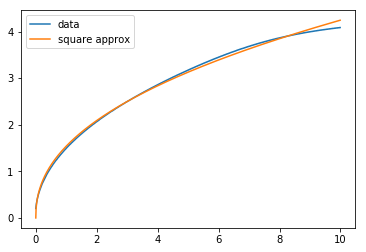

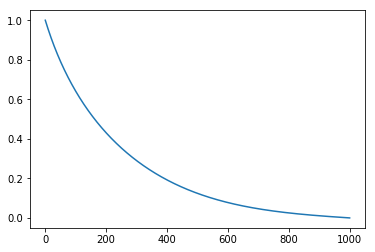

0.5 2.5854234287616134


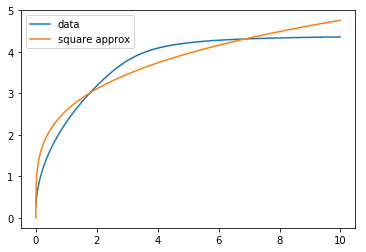

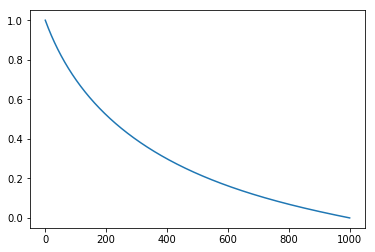

In [102]:
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x**b

Ntimesteps = 1000
tau = 0.01
x = np.arange(0,Ntimesteps*tau,tau)


Ds = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5]
ass =[]
for D in Ds:
    uImplicite, frontImplicite = ImpliciteSchemaPolar()
    ypolar = frontImplicite*h
    plt.plot(x,ypolar,label='data')
    popt, pcov = curve_fit(func, x, ypolar)
    ass.append(popt[0])
    print(D, popt[0])
    plt.plot(x,func(x,*popt),label='square approx')
    plt.legend()
    plt.show()
    plt.plot(uImplicite)
    plt.show()

[3.68766182 0.52603508]


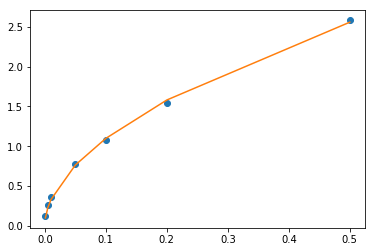

In [103]:
popt, pcov = curve_fit(func, Ds,ass)
print(popt)
plt.plot(Ds,ass,'o')
plt.plot(Ds,func(Ds,*popt),label='square approx')

In [ ]:
R0 = 0.5 #[3.68766182 0.52603508]
R0 = 1. #[3.34069427 0.4793016 ]
R0 = 2. #[3.45109491 0.48181524]


## Обработка результатов измерений

[0.32094403 1.         1.         1.        ]


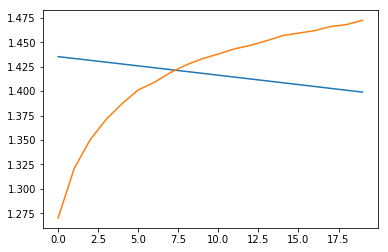

[1.61339666 1.7445079  1.82317464 1.87998951 1.92478585 1.96339083
 1.9852427  2.01328594 2.03586621 2.0540761  2.06791562 2.08284774
 2.09340947 2.1068848  2.12218111 2.12982926 2.13711322 2.14949595
 2.15532312 2.16843424 2.1757182  2.17790339 2.18591574 2.19174291
 2.19429229 2.19829847 2.20667502 2.21104539 2.21687256 2.22233553
 2.22452072 2.22816269 2.23362566 2.24018122 2.23908863 2.23981703
 2.24309481 2.24928617 2.25329235 2.25365655 2.25984791 2.25547754
 2.2609405  2.25875532 2.25948371 2.25875532 2.25984791 2.26494668
 2.26567508 2.26640347 2.27040965 2.27040965 2.26931706 2.27295904
 2.27223064 2.27295904 2.26931706 2.27368743 2.27587262 2.278422
 2.278422   2.28570596 2.2791504  2.28097139 2.28169978 2.28388497
 2.28825535 2.28534176 2.28643436 2.28825535 2.29189733 2.28716275
 2.29007634 2.2959035  2.2962677  2.2966319  2.30027388 2.29517511
 2.2962677  2.30173067 2.30100227 2.30027388 2.30136647 2.29736029
 2.30282326 2.30318746 2.30428005 2.30755783 2.30173067 2.303187

In [129]:
def func(x, a, b, c, d):
    return a*x**0.5

data1 = np.loadtxt('001.txt')
radius = data1[:20]**0.5
x = np.linspace(20,radius.size-1,radius.size)
popt, pcov = curve_fit(func, x, radius)
print(popt)
plt.plot(func(x,*popt),label='square approx')
plt.plot(radius)
plt.show()
print(data1)